In [2]:
#устанавливаем библиотеку для Time-to-Event Analysis
!pip install scikit-survival

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sksurv.preprocessing import OneHotEncoder, encode_categorical
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer
from pandas.plotting import scatter_matrix
from sksurv.metrics import (
    concordance_index_censored,
    concordance_index_ipcw,
    cumulative_dynamic_auc,
    integrated_brier_score,)
from sksurv.nonparametric import kaplan_meier_estimator
from sklearn import set_config
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.ensemble import RandomSurvivalForest
%matplotlib inline 

In [5]:
X_full = pd.read_csv('/content/METABRIC_RNA_Mutation.csv', low_memory=False)

In [6]:
clinical_df = X_full.iloc[:, :31]

In [7]:
clinical_df_inverted = clinical_df.copy()


In [8]:
clinical_df_inverted['overall_survival'] = clinical_df_inverted['overall_survival'].replace([0,1],[1,0])

In [9]:
KM_df = clinical_df_inverted.copy()

In [10]:
KM_df[['overall_survival']] = KM_df[['overall_survival']].astype(bool)

In [11]:
KM_df.drop(['patient_id', 'cohort', 'cancer_type', 'oncotree_code', 'death_from_cancer'], axis=1, inplace=True)

In [12]:
X = KM_df.copy()
X.drop(['overall_survival', 'overall_survival_months'], axis=1, inplace=True)

In [13]:
y = KM_df.copy()
y.drop(['age_at_diagnosis', 'type_of_breast_surgery',
       'cancer_type_detailed', 'cellularity', 'chemotherapy',
       'pam50_+_claudin-low_subtype', 'er_status_measured_by_ihc', 'er_status',
       'neoplasm_histologic_grade', 'her2_status_measured_by_snp6',
       'her2_status', 'tumor_other_histologic_subtype', 'hormone_therapy',
       'inferred_menopausal_state', 'integrative_cluster',
       'primary_tumor_laterality', 'lymph_nodes_examined_positive',
       'mutation_count', 'nottingham_prognostic_index','pr_status',
       'radio_therapy', '3-gene_classifier_subtype', 'tumor_size',
       'tumor_stage'], axis=1, inplace=True)

In [14]:
y_rear = y[['overall_survival', 'overall_survival_months']]

In [15]:
new_y = y_rear[['overall_survival', 'overall_survival_months']].to_numpy()

In [16]:
#Делаем структурированный массив
dt=dtype=[('overall_survival', '?'), ('overall_survival_months', '<f8')]

#Structured array
struct_y = np.array([tuple(row) for row in new_y], dtype=dt)
struct_y

array([(False, 140.5       ), (False,  84.63333333),
       ( True, 163.7       ), ..., ( True, 175.9666667 ),
       ( True,  86.23333333), ( True, 201.9       )],
      dtype=[('overall_survival', '?'), ('overall_survival_months', '<f8')])

In [17]:
num_columns = [cname for cname in X.columns if 
                X[cname].dtype in ['int64', 'float64']]
print(num_columns)

['age_at_diagnosis', 'chemotherapy', 'neoplasm_histologic_grade', 'hormone_therapy', 'lymph_nodes_examined_positive', 'mutation_count', 'nottingham_prognostic_index', 'radio_therapy', 'tumor_size', 'tumor_stage']


In [18]:
cat_columns = [cname for cname in X.columns if
                    X[cname].dtype == "object"]
print(cat_columns)

['type_of_breast_surgery', 'cancer_type_detailed', 'cellularity', 'pam50_+_claudin-low_subtype', 'er_status_measured_by_ihc', 'er_status', 'her2_status_measured_by_snp6', 'her2_status', 'tumor_other_histologic_subtype', 'inferred_menopausal_state', 'integrative_cluster', 'primary_tumor_laterality', 'pr_status', '3-gene_classifier_subtype']


In [19]:
num_pipeline = Pipeline([
    ('std_scaler', StandardScaler()),
    ('imputer', SimpleImputer(strategy='median')),
])

In [20]:
cat_pipeline = Pipeline([
    ('oe', OrdinalEncoder()),
])

In [21]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, num_columns),
        ('cat', cat_pipeline, cat_columns)
    ], remainder='passthrough')

In [22]:
preprocessor.set_output(transform='pandas')
X_pandas = preprocessor.fit_transform(X)
X_pandas

,num__age_at_diagnosis,num__chemotherapy,num__neoplasm_histologic_grade,num__hormone_therapy,num__lymph_nodes_examined_positive,num__mutation_count,num__nottingham_prognostic_index,num__radio_therapy,num__tumor_size,num__tumor_stage,...,cat__er_status_measured_by_ihc,cat__er_status,cat__her2_status_measured_by_snp6,cat__her2_status,cat__tumor_other_histologic_subtype,cat__inferred_menopausal_state,cat__integrative_cluster,cat__primary_tumor_laterality,cat__pr_status,cat__3-gene_classifier_subtype
0,1.122359,-0.512445,0.897956,0.788547,1.960788,-0.171942,1.757557,0.821330,-0.279656,0.396748,...,1.0,1.0,2.0,0.0,0.0,0.0,4.0,1.0,0.0,2.0
1,-1.379317,-0.512445,0.897956,0.788547,-0.490841,-0.911280,-0.011378,0.821330,-1.071371,-1.193646,...,1.0,1.0,2.0,0.0,0.0,1.0,4.0,1.0,1.0,0.0
2,-0.941562,1.951430,-0.639479,0.788547,-0.245678,-0.911280,-0.002638,-1.217538,-0.741490,0.396748,...,1.0,1.0,2.0,0.0,0.0,1.0,3.0,1.0,1.0,NaN
3,-1.033275,1.951430,-0.639479,0.788547,0.244648,-1.157725,0.014841,0.821330,-0.081727,0.396748,...,1.0,1.0,2.0,0.0,4.0,1.0,10.0,1.0,1.0,NaN
4,1.224091,1.951430,0.897956,0.788547,1.470462,-0.911280,1.789021,0.821330,0.907918,0.396748,...,1.0,1.0,2.0,0.0,4.0,0.0,10.0,1.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1899,-1.386253,-0.512445,0.897956,0.788547,-0.245678,-0.418388,0.888821,0.821330,-0.081727,0.396748,...,1.0,1.0,2.0,0.0,1.0,1.0,3.0,1.0,1.0,1.0
1900,-1.403208,-0.512445,0.897956,-1.268156,-0.245678,0.074504,0.880081,0.821330,-0.411608,0.396748,...,1.0,1.0,0.0,1.0,0.0,1.0,6.0,NaN,0.0,NaN
1901,0.139723,-0.512445,0.897956,0.788547,10.541487,-0.418388,1.762801,0.821330,-0.081727,0.396748,...,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,NaN
1902,0.005622,-0.512445,-0.639479,0.788547,2.451113,2.292516,0.888821,-1.217538,-0.081727,0.396748,...,1.0,1.0,2.0,0.0,0.0,0.0,0.0,NaN,1.0,0.0


In [23]:
X_pandas = X_pandas.fillna(X_pandas.median())

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X_pandas, struct_y, 
                                                                train_size=0.8, test_size=0.2,
                                                                random_state=0)

In [25]:
#Построим случайный лес с 1000 деревьев

In [26]:
rsf = RandomSurvivalForest(n_estimators=1000,
                           min_samples_split=10,
                           min_samples_leaf=15,
                           n_jobs=-1,
                           random_state=42)
rsf.fit(X_train, y_train)

RandomSurvivalForest(min_samples_leaf=15, min_samples_split=10,
                     n_estimators=1000, n_jobs=-1, random_state=42)

In [27]:
rsf.score(X_test, y_test)

0.7126262331445917

In [ ]:
#Получилось неплохо, немного выше регрессии Кокса

In [28]:
X_test_sorted = X_test.sort_values(by=["num__age_at_diagnosis", "num__nottingham_prognostic_index"])
X_test_sel = pd.concat((X_test_sorted.head(3), X_test_sorted.tail(3)))

X_test_sel

,num__age_at_diagnosis,num__chemotherapy,num__neoplasm_histologic_grade,num__hormone_therapy,num__lymph_nodes_examined_positive,num__mutation_count,num__nottingham_prognostic_index,num__radio_therapy,num__tumor_size,num__tumor_stage,...,cat__er_status_measured_by_ihc,cat__er_status,cat__her2_status_measured_by_snp6,cat__her2_status,cat__tumor_other_histologic_subtype,cat__inferred_menopausal_state,cat__integrative_cluster,cat__primary_tumor_laterality,cat__pr_status,cat__3-gene_classifier_subtype
440,-2.676396,-0.512445,0.897956,0.788547,-0.490841,-1.157725,-0.007882,0.821330,-0.939419,-1.193646,...,1.0,1.0,2.0,0.0,0.0,1.0,7.0,1.0,1.0,0.0
648,-2.476016,-0.512445,-0.639479,-1.268156,-0.490841,0.813841,-0.867878,0.821330,-0.411608,-1.193646,...,1.0,1.0,0.0,1.0,0.0,1.0,6.0,1.0,0.0,0.0
215,-2.194712,-0.512445,0.897956,-1.268156,0.734973,0.567396,1.747070,-1.217538,-0.675514,0.396748,...,0.0,0.0,0.0,1.0,0.0,1.0,6.0,0.0,0.0,3.0
190,2.184376,-0.512445,-2.176913,0.788547,-0.245678,-0.664834,-0.866130,-1.217538,-0.345632,0.396748,...,1.0,1.0,2.0,0.0,0.0,0.0,9.0,0.0,1.0,1.0
1228,2.246032,-0.512445,0.897956,0.788547,-0.245678,0.813841,0.880081,-1.217538,-0.411608,0.396748,...,1.0,1.0,2.0,0.0,0.0,0.0,8.0,0.0,1.0,1.0
200,2.393235,-0.512445,-0.639479,0.788547,1.960788,-0.418388,0.901057,0.821330,0.380108,0.396748,...,1.0,1.0,0.0,0.0,4.0,0.0,2.0,0.0,0.0,0.0


In [29]:
pd.Series(rsf.predict(X_test_sel))

0    117.578812
1    225.380755
2    691.031424
3    661.333484
4    715.136118
5    928.324578
dtype: float64

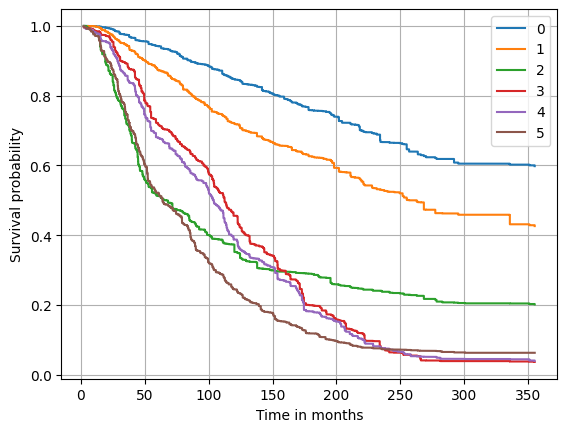

In [30]:
surv = rsf.predict_survival_function(X_test_sel, return_array=True)

for i, s in enumerate(surv):
    plt.step(rsf.event_times_, s, where="post", label=str(i))
plt.ylabel("Survival probability")
plt.xlabel("Time in months")
plt.legend()
plt.grid(True)

Permutation-based feature importance

In [31]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    rsf, X_test, y_test, n_repeats=15, random_state=42
)

In [32]:
pd.DataFrame(
    {k: result[k] for k in ("importances_mean", "importances_std",)},
    index=X_test.columns
).sort_values(by="importances_mean", ascending=False)

,importances_mean,importances_std
num__age_at_diagnosis,0.065319,0.012908
num__lymph_nodes_examined_positive,0.023484,0.005761
num__nottingham_prognostic_index,0.018623,0.005004
num__tumor_size,0.007129,0.003383
num__tumor_stage,0.003379,0.001702
cat__her2_status_measured_by_snp6,0.002178,0.001157
cat__primary_tumor_laterality,0.001554,0.000750
cat__pr_status,0.001001,0.001522
cat__pam50_+_claudin-low_subtype,0.000909,0.001650
num__radio_therapy,0.000773,0.001315


Градиентный бустинг

In [33]:
from sksurv.ensemble import ComponentwiseGradientBoostingSurvivalAnalysis
from sksurv.ensemble import GradientBoostingSurvivalAnalysis

In [34]:
est_cph_tree = GradientBoostingSurvivalAnalysis(
    n_estimators=15, learning_rate=1.0, max_depth=1, random_state=0
)
est_cph_tree.fit(X_train, y_train)
cindex = est_cph_tree.score(X_test, y_test)
print(round(cindex, 3))

0.706


In [35]:
scores_cph_tree = {}

est_cph_tree = GradientBoostingSurvivalAnalysis(
    learning_rate=1.0, max_depth=1, random_state=0
)
for i in range(1, 25):
    n_estimators = i * 5
    est_cph_tree.set_params(n_estimators=n_estimators)
    est_cph_tree.fit(X_train, y_train)
    scores_cph_tree[n_estimators] = est_cph_tree.score(X_test, y_test)

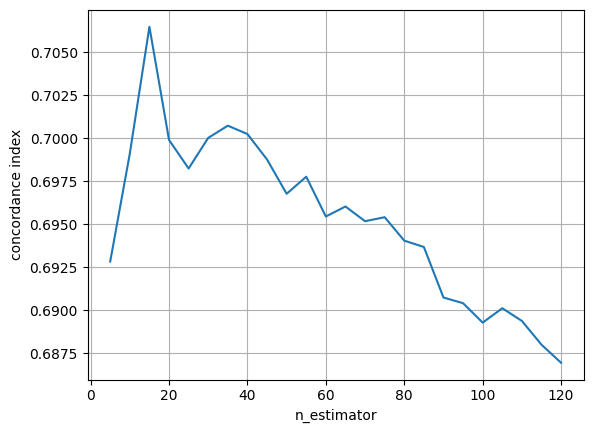

In [36]:
x, y = zip(*scores_cph_tree.items())
plt.plot(x, y)
plt.xlabel("n_estimator")
plt.ylabel("concordance index")
plt.grid(True)

In [37]:
scores_cph_ls = {}

est_cph_ls = ComponentwiseGradientBoostingSurvivalAnalysis(
    learning_rate=1.0, random_state=0
)
for i in range(1, 31):
    n_estimators = i * 10
    est_cph_ls.set_params(n_estimators=n_estimators)
    est_cph_ls.fit(X_train, y_train)
    scores_cph_ls[n_estimators] = est_cph_ls.score(X_test, y_test)

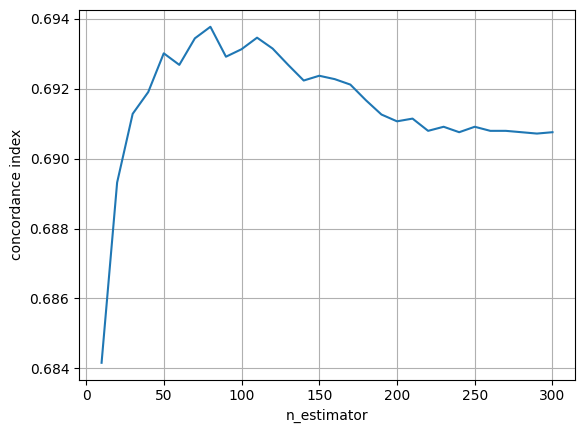

In [38]:
x, y = zip(*scores_cph_ls.items())
plt.plot(x, y)
plt.xlabel("n_estimator")
plt.ylabel("concordance index")
plt.grid(True)

In [39]:
coef = pd.Series(est_cph_ls.coef_, ["Intercept"] + X_pandas.columns.tolist())

print("Number of non-zero coefficients:", (coef != 0).sum())
coef_nz = coef[coef != 0]
coef_order = coef_nz.abs().sort_values(ascending=False).index
coef_nz.loc[coef_order]

Number of non-zero coefficients: 21


num__age_at_diagnosis                  0.605287
cat__her2_status                       0.405688
cat__inferred_menopausal_state         0.394660
cat__er_status                        -0.346895
num__lymph_nodes_examined_positive     0.167206
cat__3-gene_classifier_subtype        -0.155464
num__tumor_stage                       0.130467
num__radio_therapy                    -0.129671
cat__cancer_type_detailed              0.120184
num__nottingham_prognostic_index       0.119576
num__chemotherapy                      0.103823
num__tumor_size                        0.100227
cat__primary_tumor_laterality         -0.098944
cat__tumor_other_histologic_subtype   -0.077298
cat__her2_status_measured_by_snp6     -0.063747
cat__pr_status                        -0.054941
cat__type_of_breast_surgery            0.049470
num__hormone_therapy                  -0.035895
num__neoplasm_histologic_grade         0.020068
num__mutation_count                    0.003058
cat__pam50_+_claudin-low_subtype       0

Регуляризация

In [40]:
n_estimators = [i * 5 for i in range(1, 21)]

estimators = {
    "no regularization": GradientBoostingSurvivalAnalysis(
        learning_rate=1.0, max_depth=1, random_state=0
    ),
    "learning rate": GradientBoostingSurvivalAnalysis(
        learning_rate=0.1, max_depth=1, random_state=0
    ),
    "dropout": GradientBoostingSurvivalAnalysis(
        learning_rate=1.0, dropout_rate=0.1, max_depth=1, random_state=0
    ),
    "subsample": GradientBoostingSurvivalAnalysis(
        learning_rate=1.0, subsample=0.5, max_depth=1, random_state=0
    ),
}

scores_reg = {k: [] for k in estimators.keys()}
for n in n_estimators:
    for name, est in estimators.items():
        est.set_params(n_estimators=n)
        est.fit(X_train, y_train)
        cindex = est.score(X_test, y_test)
        scores_reg[name].append(cindex)

scores_reg = pd.DataFrame(scores_reg, index=n_estimators)

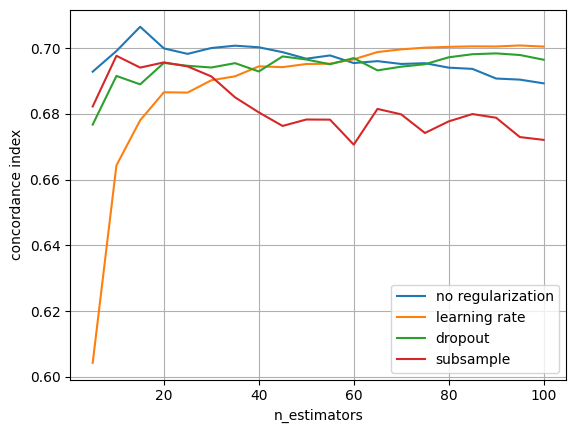

In [41]:
ax = scores_reg.plot(xlabel="n_estimators", ylabel="concordance index")
ax.grid(True)

In [42]:
class EarlyStoppingMonitor:

    def __init__(self, window_size, max_iter_without_improvement):
        self.window_size = window_size
        self.max_iter_without_improvement = max_iter_without_improvement
        self._best_step = -1

    def __call__(self, iteration, estimator, args):
        if iteration < self.window_size:
            return False


        start = iteration - self.window_size + 1
        end = iteration + 1
        improvement = np.mean(estimator.oob_improvement_[start:end])

        if improvement > 1e-6:
            self._best_step = iteration
            return False  

        diff = iteration - self._best_step
        return diff >= self.max_iter_without_improvement


est_early_stopping = GradientBoostingSurvivalAnalysis(
    n_estimators=1000, learning_rate=0.05, subsample=0.5,
    max_depth=1, random_state=0
)

monitor = EarlyStoppingMonitor(25, 50)

est_early_stopping.fit(X_train, y_train, monitor=monitor)

print("Fitted base learners:", est_early_stopping.n_estimators_)

cindex = est_early_stopping.score(X_test, y_test)
print("Performance on test set", round(cindex, 3))

Fitted base learners: 254
Performance on test set 0.707


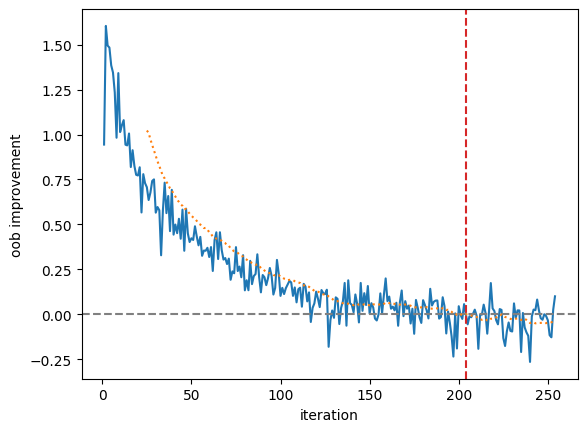

In [43]:
improvement = pd.Series(
    est_early_stopping.oob_improvement_,
    index=np.arange(1, 1 + len(est_early_stopping.oob_improvement_))
)
ax = improvement.plot(xlabel="iteration", ylabel="oob improvement")
ax.axhline(0.0, linestyle="--", color="gray")
cutoff = len(improvement) - monitor.max_iter_without_improvement
ax.axvline(cutoff, linestyle="--", color="C3")

_ = improvement.rolling(monitor.window_size).mean().plot(ax=ax, linestyle=":")

In [44]:
#Оценим ситуацию с генетическими признаками
gene_df = X_full.iloc[:,31:520]

In [45]:
gene_df = gene_df.fillna(gene_df.median())

In [46]:
X_train_gen, X_test_gen, y_train_gen, y_test_gen = train_test_split(gene_df, struct_y, 
                                                                train_size=0.8, test_size=0.2,
                                                                random_state=0)

In [47]:
rsf = RandomSurvivalForest(n_estimators=1000,
                           min_samples_split=10,
                           min_samples_leaf=15,
                           n_jobs=-1,
                           random_state=42)
rsf.fit(X_train_gen, y_train_gen)

RandomSurvivalForest(min_samples_leaf=15, min_samples_split=10,
                     n_estimators=1000, n_jobs=-1, random_state=42)

In [48]:
rsf.score(X_test_gen, y_test_gen)

0.6313116572295838

In [49]:
X_test_gen_sorted = X_test_gen.sort_values(by=["bcl2", "stat5a"])
X_test_gen_sel = pd.concat((X_test_gen_sorted.head(3), X_test_gen_sorted.tail(3)))

X_test_gen_sel

,brca1,brca2,palb2,pten,tp53,atm,cdh1,chek2,nbn,nf1,...,srd5a1,srd5a2,srd5a3,st7,star,tnk2,tulp4,ugt2b15,ugt2b17,ugt2b7
215,-0.8045,1.2293,3.3550,-0.8025,1.5341,-0.4110,1.8186,1.8335,0.7291,-0.1028,...,3.1934,1.2170,0.1706,-0.5349,0.0732,-1.2303,0.1394,1.7499,0.2821,2.6690
789,1.1492,0.6582,0.5126,-0.4224,0.1296,-0.4190,0.2769,-0.6414,1.0794,1.5402,...,-0.5478,-0.2199,-0.6297,0.7456,-0.9081,0.4116,0.6641,-0.6054,0.2430,1.0493
1027,0.6505,0.3042,-0.7100,-0.2571,-1.8293,0.4883,0.0518,0.9822,-0.8829,-0.4095,...,0.6621,2.8272,4.2223,0.1623,-0.7662,0.5513,-1.1782,-0.5236,-0.9854,-0.0349
861,1.9236,-0.2295,0.0866,1.8619,-1.2574,-0.9589,0.4138,-0.3165,0.4086,1.5836,...,-1.1832,0.1756,1.3971,-1.3393,-0.5539,1.3938,1.4373,-0.1188,0.0412,-0.8897
1070,1.4055,-0.7108,0.1382,-1.3895,-1.2188,-1.6878,-0.7060,1.1265,0.1389,0.2179,...,-1.2360,0.2365,-1.0600,-0.4937,-0.3137,3.1363,2.7235,-0.3091,-0.0989,0.0222
459,0.6513,-1.9366,-0.4935,-0.5425,0.5461,-0.6994,0.6438,-0.9960,0.0411,1.9237,...,-0.0397,-1.2322,-1.0563,-1.6288,-0.9336,1.0487,0.5501,-0.4714,-0.2200,-0.6755


In [50]:
pd.Series(rsf.predict(X_test_gen_sel))

0    670.361490
1    681.245523
2    677.496600
3    440.783619
4    552.705976
5    468.418979
dtype: float64

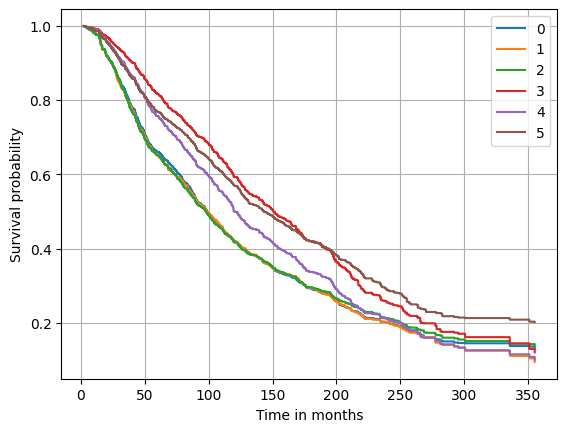

In [51]:
surv = rsf.predict_survival_function(X_test_gen_sel, return_array=True)

for i, s in enumerate(surv):
    plt.step(rsf.event_times_, s, where="post", label=str(i))
plt.ylabel("Survival probability")
plt.xlabel("Time in months")
plt.legend()
plt.grid(True)

In [52]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    rsf, X_test_gen, y_test_gen, n_repeats=15, random_state=42
)

In [53]:
pd.DataFrame(
    {k: result[k] for k in ("importances_mean", "importances_std",)},
    index=X_test_gen.columns
).sort_values(by="importances_mean", ascending=False)

,importances_mean,importances_std
flt3,0.005608,0.003474
stat5a,0.004822,0.003458
ncoa3,0.001728,0.001078
hsd3b7,0.001654,0.000753
cir1,0.001601,0.001377
...,...,...
acvr2a,-0.000926,0.001213
stat5b,-0.000933,0.001073
mmp11,-0.001095,0.000946
mmp15,-0.001208,0.000676


In [54]:
#Градиентный бустинг
est_cph_tree = GradientBoostingSurvivalAnalysis(
    n_estimators=15, learning_rate=1.0, max_depth=1, random_state=0
)
est_cph_tree.fit(X_train_gen, y_train_gen)
cindex = est_cph_tree.score(X_test_gen, y_test_gen)
print(round(cindex, 3))

0.608


In [55]:
scores_cph_tree = {}

est_cph_tree = GradientBoostingSurvivalAnalysis(
    learning_rate=1.0, max_depth=1, random_state=0
)
for i in range(1, 25):
    n_estimators = i * 5
    est_cph_tree.set_params(n_estimators=n_estimators)
    est_cph_tree.fit(X_train_gen, y_train_gen)
    scores_cph_tree[n_estimators] = est_cph_tree.score(X_test_gen, y_test_gen)

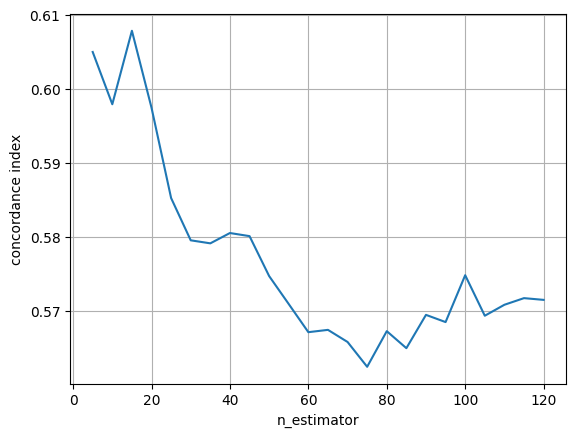

In [56]:
x, y = zip(*scores_cph_tree.items())
plt.plot(x, y)
plt.xlabel("n_estimator")
plt.ylabel("concordance index")
plt.grid(True)

In [57]:
scores_cph_ls = {}

est_cph_ls = ComponentwiseGradientBoostingSurvivalAnalysis(
    learning_rate=1.0, random_state=0
)
for i in range(1, 31):
    n_estimators = i * 10
    est_cph_ls.set_params(n_estimators=n_estimators)
    est_cph_ls.fit(X_train_gen, y_train_gen)
    scores_cph_ls[n_estimators] = est_cph_ls.score(X_test_gen, y_test_gen)

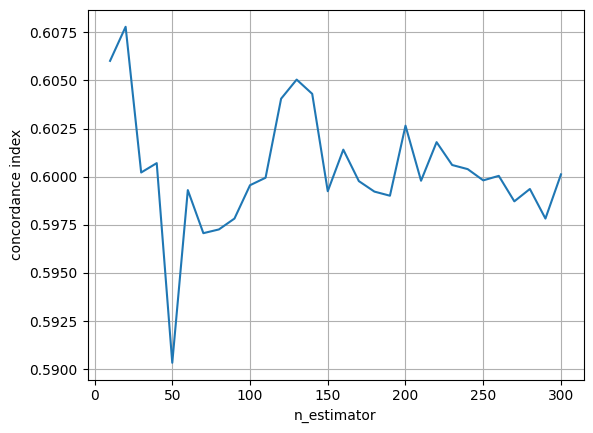

In [58]:
x, y = zip(*scores_cph_ls.items())
plt.plot(x, y)
plt.xlabel("n_estimator")
plt.ylabel("concordance index")
plt.grid(True)

In [59]:
coef = pd.Series(est_cph_ls.coef_, ["Intercept"] + gene_df.columns.tolist())

print("Number of non-zero coefficients:", (coef != 0).sum())
coef_nz = coef[coef != 0]
coef_order = coef_nz.abs().sort_values(ascending=False).index
coef_nz.loc[coef_order]

Number of non-zero coefficients: 190


ccnb1      0.130068
stat5a    -0.125949
cdkn2a    -0.123635
gsk3b      0.122820
tgfbr2     0.106132
             ...   
msh2       0.014187
e2f1       0.014181
chek1     -0.014176
alk       -0.014158
izumo1r   -0.013980
Length: 190, dtype: float64

In [60]:
#регуляризация
n_estimators = [i * 5 for i in range(1, 21)]

estimators = {
    "no regularization": GradientBoostingSurvivalAnalysis(
        learning_rate=1.0, max_depth=1, random_state=0
    ),
    "learning rate": GradientBoostingSurvivalAnalysis(
        learning_rate=0.1, max_depth=1, random_state=0
    ),
    "dropout": GradientBoostingSurvivalAnalysis(
        learning_rate=1.0, dropout_rate=0.1, max_depth=1, random_state=0
    ),
    "subsample": GradientBoostingSurvivalAnalysis(
        learning_rate=1.0, subsample=0.5, max_depth=1, random_state=0
    ),
}

scores_reg = {k: [] for k in estimators.keys()}
for n in n_estimators:
    for name, est in estimators.items():
        est.set_params(n_estimators=n)
        est.fit(X_train_gen, y_train_gen)
        cindex = est.score(X_test_gen, y_test_gen)
        scores_reg[name].append(cindex)

scores_reg = pd.DataFrame(scores_reg, index=n_estimators)

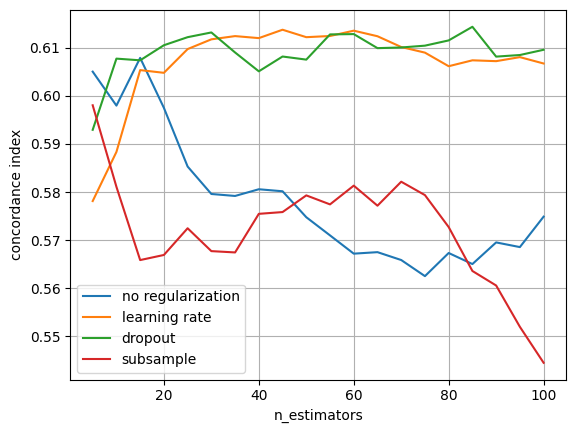

In [61]:
ax = scores_reg.plot(xlabel="n_estimators", ylabel="concordance index")
ax.grid(True)

In [62]:
class EarlyStoppingMonitor:

    def __init__(self, window_size, max_iter_without_improvement):
        self.window_size = window_size
        self.max_iter_without_improvement = max_iter_without_improvement
        self._best_step = -1

    def __call__(self, iteration, estimator, args):
        
        if iteration < self.window_size:
            return False


        start = iteration - self.window_size + 1
        end = iteration + 1
        improvement = np.mean(estimator.oob_improvement_[start:end])

        if improvement > 1e-6:
            self._best_step = iteration
            return False  

        diff = iteration - self._best_step
        return diff >= self.max_iter_without_improvement


est_early_stopping = GradientBoostingSurvivalAnalysis(
    n_estimators=1000, learning_rate=0.05, subsample=0.5,
    max_depth=1, random_state=0
)

monitor = EarlyStoppingMonitor(25, 50)

est_early_stopping.fit(X_train_gen, y_train_gen, monitor=monitor)

print("Fitted base learners:", est_early_stopping.n_estimators_)

cindex = est_early_stopping.score(X_test_gen, y_test_gen)
print("Performance on test set", round(cindex, 3))

Fitted base learners: 227
Performance on test set 0.614


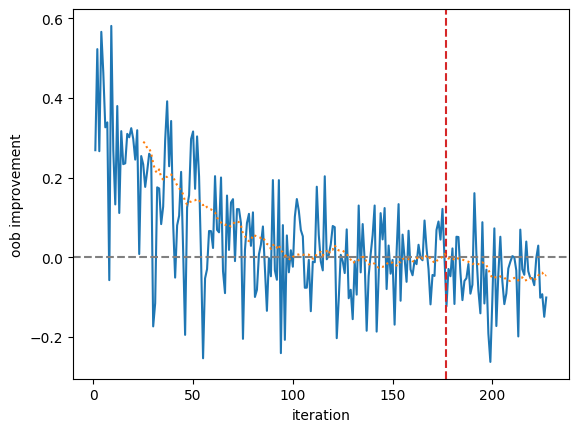

In [63]:
improvement = pd.Series(
    est_early_stopping.oob_improvement_,
    index=np.arange(1, 1 + len(est_early_stopping.oob_improvement_))
)
ax = improvement.plot(xlabel="iteration", ylabel="oob improvement")
ax.axhline(0.0, linestyle="--", color="gray")
cutoff = len(improvement) - monitor.max_iter_without_improvement
ax.axvline(cutoff, linestyle="--", color="C3")

_ = improvement.rolling(monitor.window_size).mean().plot(ax=ax, linestyle=":")